# Pneumonia Detection using Deep Learning
## Chest X-Ray Classification: CNN vs Transfer Learning (DenseNet121)


In [1]:
#1. Check GPU Availability
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is enabled! Training will be faster.")
else:
    print("⚠️ No GPU detected. Go to Runtime → Change runtime type → GPU")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is enabled! Training will be faster.


In [2]:
#2. Import Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
#3. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Google Drive mounted successfully!")

Mounted at /content/drive

✅ Google Drive mounted successfully!


In [4]:
#4. Set Dataset Paths & Verify Data

BASE_PATH = "/content/drive/MyDrive/Deep Learning project/chest_xray"

train_dir = os.path.join(BASE_PATH, "train")
val_dir = os.path.join(BASE_PATH, "val")
test_dir = os.path.join(BASE_PATH, "test")

# Verify paths exist
print("Checking dataset paths...")
for name, path in [("Train", train_dir), ("Val", val_dir), ("Test", test_dir)]:
    if os.path.exists(path):
        print(f"✅ {name}: {path}")
    else:
        print(f"❌ {name} path not found: {path}")

# Show dataset statistics
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
for split, path in [("Train", train_dir), ("Val", val_dir), ("Test", test_dir)]:
    try:
        normal = len(os.listdir(os.path.join(path, "NORMAL")))
        pneumonia = len(os.listdir(os.path.join(path, "PNEUMONIA")))
        print(f"{split:6} → NORMAL: {normal:4} | PNEUMONIA: {pneumonia:4} | Total: {normal+pneumonia}")
    except:
        print(f"{split}: Could not read directory")

Checking dataset paths...
✅ Train: /content/drive/MyDrive/Deep Learning project/chest_xray/train
✅ Val: /content/drive/MyDrive/Deep Learning project/chest_xray/val
✅ Test: /content/drive/MyDrive/Deep Learning project/chest_xray/test

DATASET STATISTICS
Train  → NORMAL: 1341 | PNEUMONIA: 3875 | Total: 5216
Val    → NORMAL:    8 | PNEUMONIA:    8 | Total: 16
Test   → NORMAL:  234 | PNEUMONIA:  390 | Total: 624


In [5]:
#5. Data Generators with IMPROVED Validation Split
# FIX: Original validation set only had 16 images - too small!
# We use 15% of training data for validation instead

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # FIX: Use 15% of training data for validation
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training set (85% of original training data)
print("Loading training data...")
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True
)

# Validation set (15% of original training data)
print("Loading validation data...")
val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

# Test set
print("Loading test data...")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\n" + "="*50)
print("DATA SPLIT SUMMARY")
print("="*50)
print(f"✅ Training samples:   {train_data.samples}")
print(f"✅ Validation samples: {val_data.samples} (was only 16 before!)")
print(f"✅ Test samples:       {test_data.samples}")
print(f"\nClass mapping: {train_data.class_indices}")

Loading training data...
Found 4434 images belonging to 2 classes.
Loading validation data...
Found 782 images belonging to 2 classes.
Loading test data...
Found 624 images belonging to 2 classes.

DATA SPLIT SUMMARY
✅ Training samples:   4434
✅ Validation samples: 782 (was only 16 before!)
✅ Test samples:       624

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


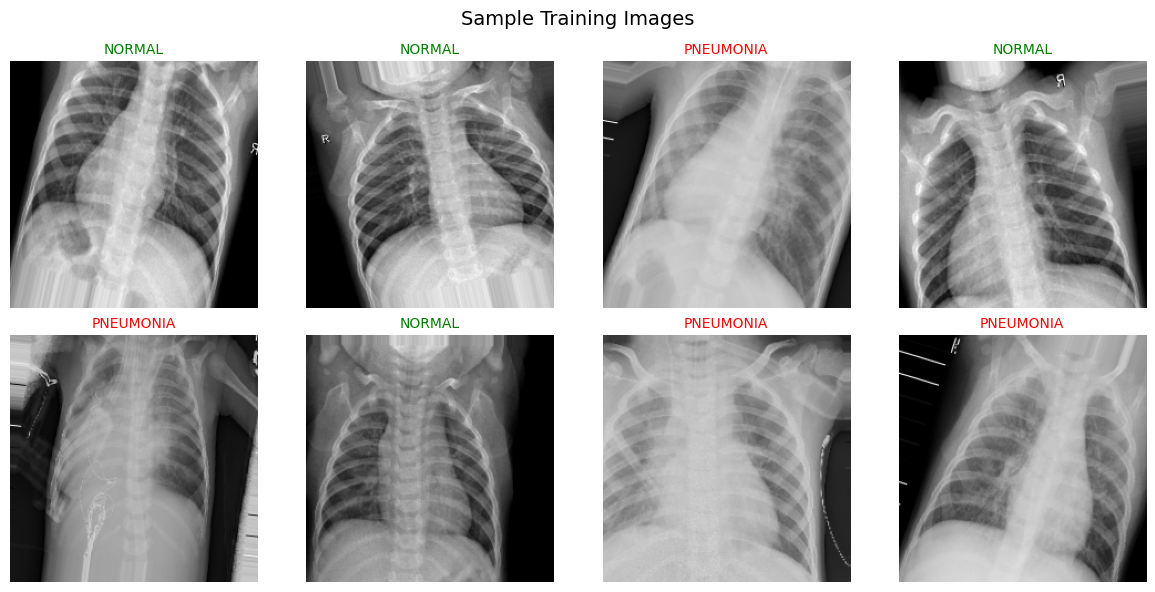

In [6]:
#6. Visualize Sample Images
plt.figure(figsize=(12, 6))

# Get a batch of images
images, labels = next(train_data)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    label = 'PNEUMONIA' if labels[i] == 1 else 'NORMAL'
    color = 'red' if labels[i] == 1 else 'green'
    plt.title(label, color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Training Images', fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
#7. Compute Class Weights (FIX for class imbalance)
# Dataset has more PNEUMONIA than NORMAL images
# Class weights make the model pay more attention to minority class

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("="*50)
print("CLASS WEIGHTS (to handle imbalance)")
print("="*50)
print(f"Class 0 (NORMAL):    {class_weight_dict[0]:.4f} ← Higher weight (fewer samples)")
print(f"Class 1 (PNEUMONIA): {class_weight_dict[1]:.4f} ← Lower weight (more samples)")

CLASS WEIGHTS (to handle imbalance)
Class 0 (NORMAL):    1.9447 ← Higher weight (fewer samples)
Class 1 (PNEUMONIA): 0.6730 ← Lower weight (more samples)


In [8]:
#8. Define Callbacks (FIX for overfitting)

# Early Stopping: Stop when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Reduction: Reduce LR when plateauing
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, lr_scheduler]
print("✅ Callbacks defined:")
print("   • EarlyStopping (patience=5)")
print("   • ReduceLROnPlateau (factor=0.5, patience=3)")

✅ Callbacks defined:
   • EarlyStopping (patience=5)
   • ReduceLROnPlateau (factor=0.5, patience=3)


---
## 🔷 BASELINE MODEL: Improved CNN
### Architecture Improvements:
- Batch Normalization for stable training
- GlobalAveragePooling2D instead of Flatten
- Progressive filter sizes (32→64→128→256)
- Proper dropout placement

In [9]:
#9. Build Improved CNN Model
def build_cnn_model():
    model = tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # Block 2
        tf.keras.layers.Conv2D(64, (3,3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # Block 3
        tf.keras.layers.Conv2D(128, (3,3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # Block 4
        tf.keras.layers.Conv2D(256, (3,3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # Classifier Head
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = build_cnn_model()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("CNN Model Summary:")
print("="*50)
cnn_model.summary()

CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 457,409 (1.74 MB)

 Trainable params: 455,937 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [10]:
#10. Train CNN Model
print("="*60)
print("TRAINING CNN MODEL")
print("="*60)
print("Using: Early Stopping + LR Scheduler + Class Weights")
print("-"*60)

cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

TRAINING CNN MODEL
Using: Early Stopping + LR Scheduler + Class Weights
------------------------------------------------------------
Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 1249s 9s/step - accuracy: 0.8207 - loss: 0.3987 - val_accuracy: 0.7430 - val_loss: 0.9380 - learning_rate: 1.0000e-04
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 116s 838ms/step - accuracy: 0.8653 - loss: 0.3130 - val_accuracy: 0.7430 - val_loss: 1.7842 - learning_rate: 1.0000e-04
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 116s 833ms/step - accuracy: 0.8957 - loss: 0.2544 - val_accuracy: 0.7430 - val_loss: 2.0992 - learning_rate: 1.0000e-04
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.8960 - loss: 0.2419
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
139/139 ━━━━━━━━━━━━━━━━━━━━ 114s 819ms/step - accuracy: 0.8960 - loss: 0.2419 - val_accuracy: 0.7430 - val_loss: 2.3496 - learning_rate: 1.0000e-04
Epoch 5/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 115s 827ms/step - accuracy: 0.9019 -

In [11]:
#11. Evaluate CNN on Test Set
print("\nEvaluating CNN on Test Set...")
cnn_loss, cnn_acc = cnn_model.evaluate(test_data, verbose=1)
print("\n" + "="*50)
print(f"✅ CNN TEST ACCURACY: {cnn_acc*100:.2f}%")
print(f"   CNN Test Loss: {cnn_loss:.4f}")
print("="*50)


Evaluating CNN on Test Set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 178s 9s/step - accuracy: 0.2984 - loss: 2.5187

✅ CNN TEST ACCURACY: 62.50%
   CNN Test Loss: 1.3582


---
## 🔶 TRANSFER LEARNING: DenseNet121
### Why DenseNet121?
- Pre-trained on ImageNet (1M+ images)
- Dense connections help feature reuse
- Excellent for medical imaging tasks
- Only training the classification head

In [12]:
#12. Build DenseNet121 Model
print("Loading pre-trained DenseNet121...")

# Load pre-trained DenseNet121 (without top layers)
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

densenet_model = Model(inputs=base_model.input, outputs=output)

densenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Count parameters
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])

print("\n" + "="*50)
print("DenseNet121 MODEL SUMMARY")
print("="*50)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters:    {total_params - trainable_params:,}")

Loading pre-trained DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

DenseNet121 MODEL SUMMARY
Total parameters:     7,305,281
Trainable parameters: 265,217
Frozen parameters:    7,040,064


In [13]:
#13. Train DenseNet121 Model
print("="*60)
print("TRAINING DenseNet121 MODEL")
print("="*60)
print("Using: Early Stopping + LR Scheduler + Class Weights")
print("-"*60)

densenet_history = densenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

TRAINING DenseNet121 MODEL
Using: Early Stopping + LR Scheduler + Class Weights
------------------------------------------------------------
Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.6824 - loss: 0.5530 - val_accuracy: 0.8107 - val_loss: 0.4401 - learning_rate: 1.0000e-04
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 117s 839ms/step - accuracy: 0.8328 - loss: 0.3245 - val_accuracy: 0.8760 - val_loss: 0.3208 - learning_rate: 1.0000e-04
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 116s 838ms/step - accuracy: 0.8470 - loss: 0.3019 - val_accuracy: 0.9003 - val_loss: 0.2538 - learning_rate: 1.0000e-04
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 116s 833ms/step - accuracy: 0.8730 - loss: 0.2621 - val_accuracy: 0.9054 - val_loss: 0.2627 - learning_rate: 1.0000e-04
Epoch 5/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 117s 837ms/step - accuracy: 0.9028 - loss: 0.2224 - val_accuracy: 0.9054 - val_loss: 0.2532 - learning_rate: 1.0000e-04
Epoch 6/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 116s 839ms/step - accu

In [14]:
#14. Evaluate DenseNet121 on Test Set
print("\nEvaluating DenseNet121 on Test Set...")
densenet_loss, densenet_acc = densenet_model.evaluate(test_data, verbose=1)
print("\n" + "="*50)
print(f"✅ DenseNet121 TEST ACCURACY: {densenet_acc*100:.2f}%")
print(f"   DenseNet121 Test Loss: {densenet_loss:.4f}")
print("="*50)


Evaluating DenseNet121 on Test Set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 870ms/step - accuracy: 0.8897 - loss: 0.2661

✅ DenseNet121 TEST ACCURACY: 89.10%
   DenseNet121 Test Loss: 0.2564


---
## 📊 EVALUATION & VISUALIZATION

CNN Training History:


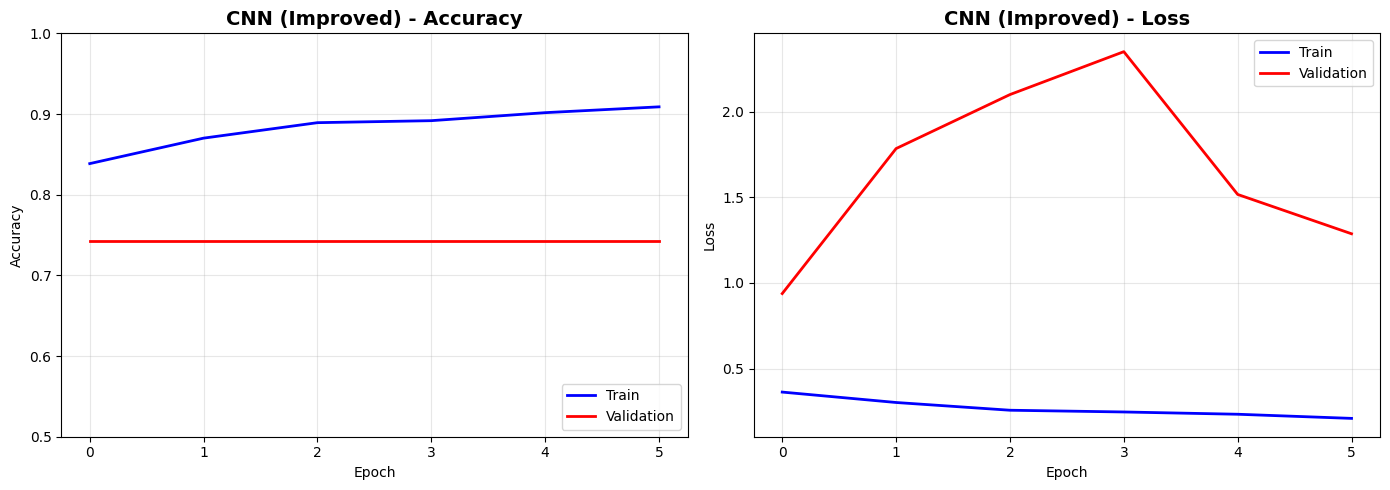

In [15]:
#15. Plot Training History - CNN
def plot_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], 'b-', label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0.5, 1.0])

    # Loss
    axes[1].plot(history.history['loss'], 'b-', label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[1].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("CNN Training History:")
plot_history(cnn_history, "CNN (Improved)")

DenseNet121 Training History:


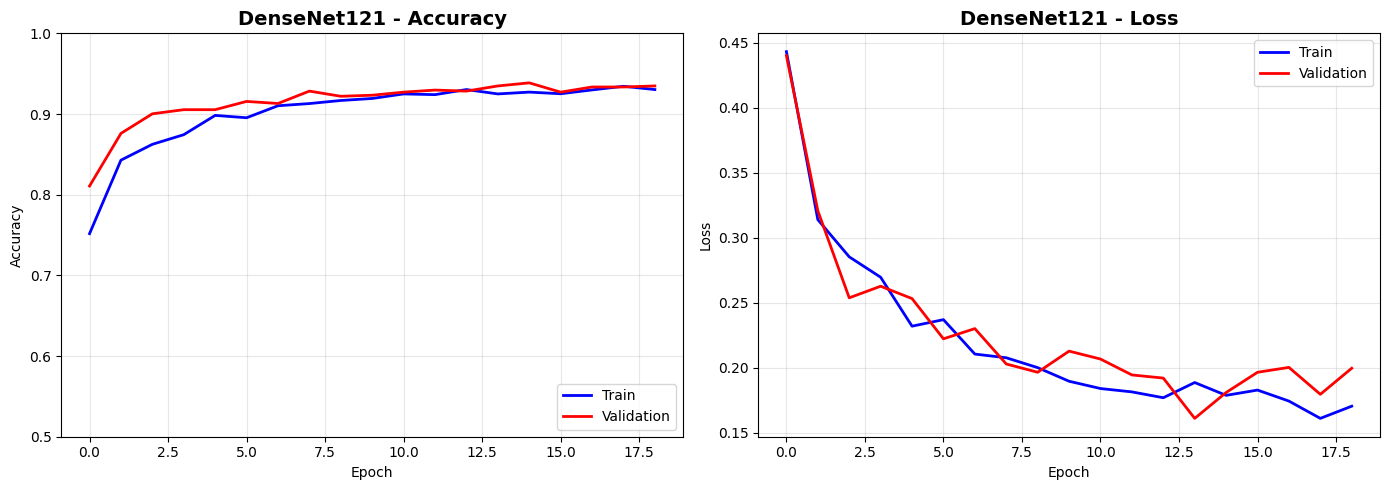

In [16]:
#16. Plot Training History - DenseNet121
print("DenseNet121 Training History:")
plot_history(densenet_history, "DenseNet121")

In [17]:
#17. Generate Predictions (using best model - DenseNet121)
print("Generating predictions on test set...")
test_data.reset()

y_pred_proba = densenet_model.predict(test_data, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_data.classes

print(f"\n✅ Predictions generated for {len(y_true)} test images")

Generating predictions on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 955ms/step

✅ Predictions generated for 624 test images


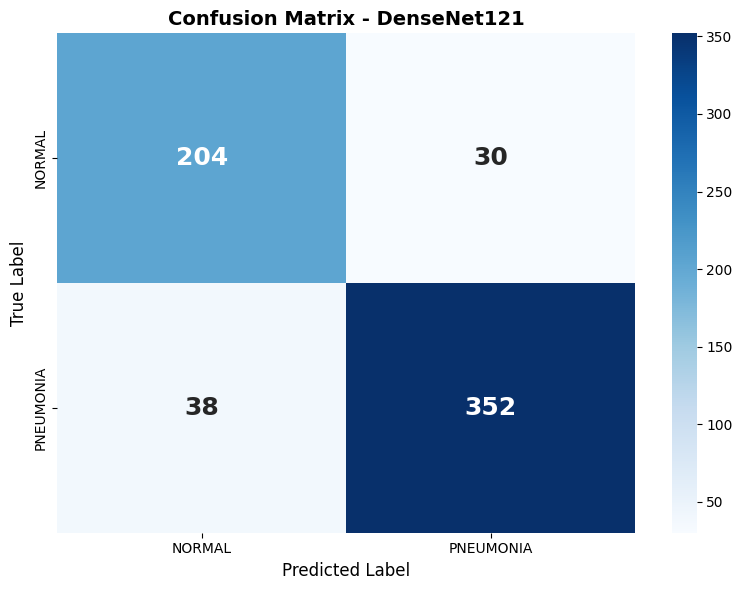


Confusion Matrix Breakdown:
  True Negatives  (NORMAL → NORMAL):     204
  False Positives (NORMAL → PNEUMONIA):  30
  False Negatives (PNEUMONIA → NORMAL):  38 ← We want this LOW
  True Positives  (PNEUMONIA → PNEUMONIA): 352


In [18]:
#18. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            annot_kws={'size': 18, 'fontweight': 'bold'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - DenseNet121', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Extract values
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives  (NORMAL → NORMAL):     {tn}")
print(f"  False Positives (NORMAL → PNEUMONIA):  {fp}")
print(f"  False Negatives (PNEUMONIA → NORMAL):  {fn} ← We want this LOW")
print(f"  True Positives  (PNEUMONIA → PNEUMONIA): {tp}")

In [19]:
#19. Classification Report
print("="*60)
print("CLASSIFICATION REPORT - DenseNet121")
print("="*60)
print(classification_report(y_true, y_pred,
                            target_names=['NORMAL', 'PNEUMONIA'],
                            digits=3))

# Calculate additional metrics
sensitivity = tp / (tp + fn)  # Recall for positive class
specificity = tn / (tn + fp)  # Recall for negative class

print("-"*60)
print(f"Sensitivity (Pneumonia Detection Rate): {sensitivity*100:.1f}%")
print(f"Specificity (Normal Detection Rate):    {specificity*100:.1f}%")

CLASSIFICATION REPORT - DenseNet121
              precision    recall  f1-score   support

      NORMAL      0.843     0.872     0.857       234
   PNEUMONIA      0.921     0.903     0.912       390

    accuracy                          0.891       624
   macro avg      0.882     0.887     0.885       624
weighted avg      0.892     0.891     0.891       624

------------------------------------------------------------
Sensitivity (Pneumonia Detection Rate): 90.3%
Specificity (Normal Detection Rate):    87.2%


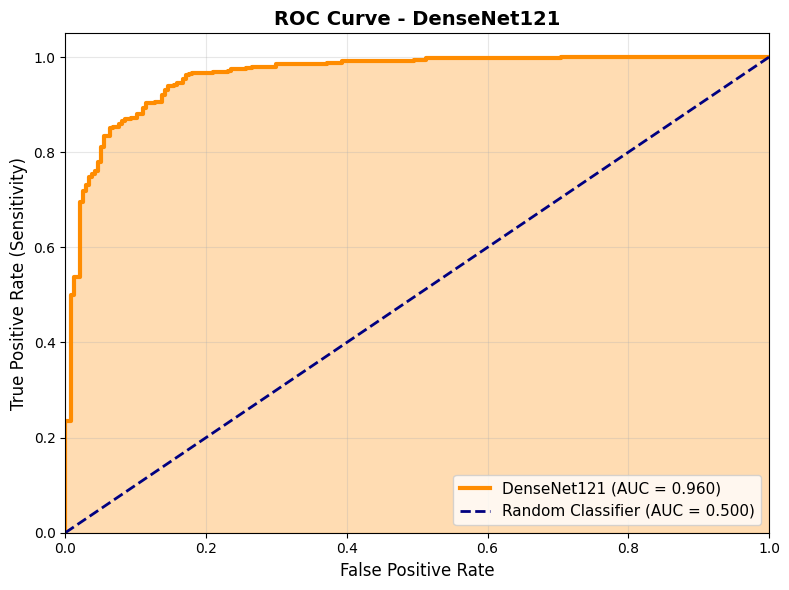


✅ Area Under ROC Curve (AUC): 0.960
   Interpretation: Excellent classifier!


In [20]:
#20. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3,
         label=f'DenseNet121 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.500)')
plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve - DenseNet121', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Area Under ROC Curve (AUC): {roc_auc:.3f}")
if roc_auc >= 0.9:
    print("   Interpretation: Excellent classifier!")
elif roc_auc >= 0.8:
    print("   Interpretation: Good classifier")
elif roc_auc >= 0.7:
    print("   Interpretation: Fair classifier")

In [21]:
#21. Model Comparison Summary
print("\n")
print("╔" + "═"*58 + "╗")
print("║" + " MODEL COMPARISON SUMMARY ".center(58) + "║")
print("╠" + "═"*58 + "╣")
print("║  {:<20} {:>15} {:>15}  ║".format("Model", "Test Accuracy", "Test Loss"))
print("╠" + "═"*58 + "╣")
print("║  {:<20} {:>14.2f}% {:>15.4f}  ║".format("CNN (Improved)", cnn_acc*100, cnn_loss))
print("║  {:<20} {:>14.2f}% {:>15.4f}  ║".format("DenseNet121", densenet_acc*100, densenet_loss))
print("╠" + "═"*58 + "╣")

improvement = (densenet_acc - cnn_acc) * 100
print("║  {:<56}  ║".format(f"📈 DenseNet121 vs CNN: {improvement:+.2f}%"))
print("║  {:<56}  ║".format(f"📊 DenseNet121 AUC: {roc_auc:.3f}"))
print("╚" + "═"*58 + "╝")



╔══════════════════════════════════════════════════════════╗
║                 MODEL COMPARISON SUMMARY                 ║
╠══════════════════════════════════════════════════════════╣
║  Model                  Test Accuracy       Test Loss  ║
╠══════════════════════════════════════════════════════════╣
║  CNN (Improved)                62.50%          1.3582  ║
║  DenseNet121                   89.10%          0.2564  ║
╠══════════════════════════════════════════════════════════╣
║  📈 DenseNet121 vs CNN: +26.60%                             ║
║  📊 DenseNet121 AUC: 0.960                                  ║
╚══════════════════════════════════════════════════════════╝


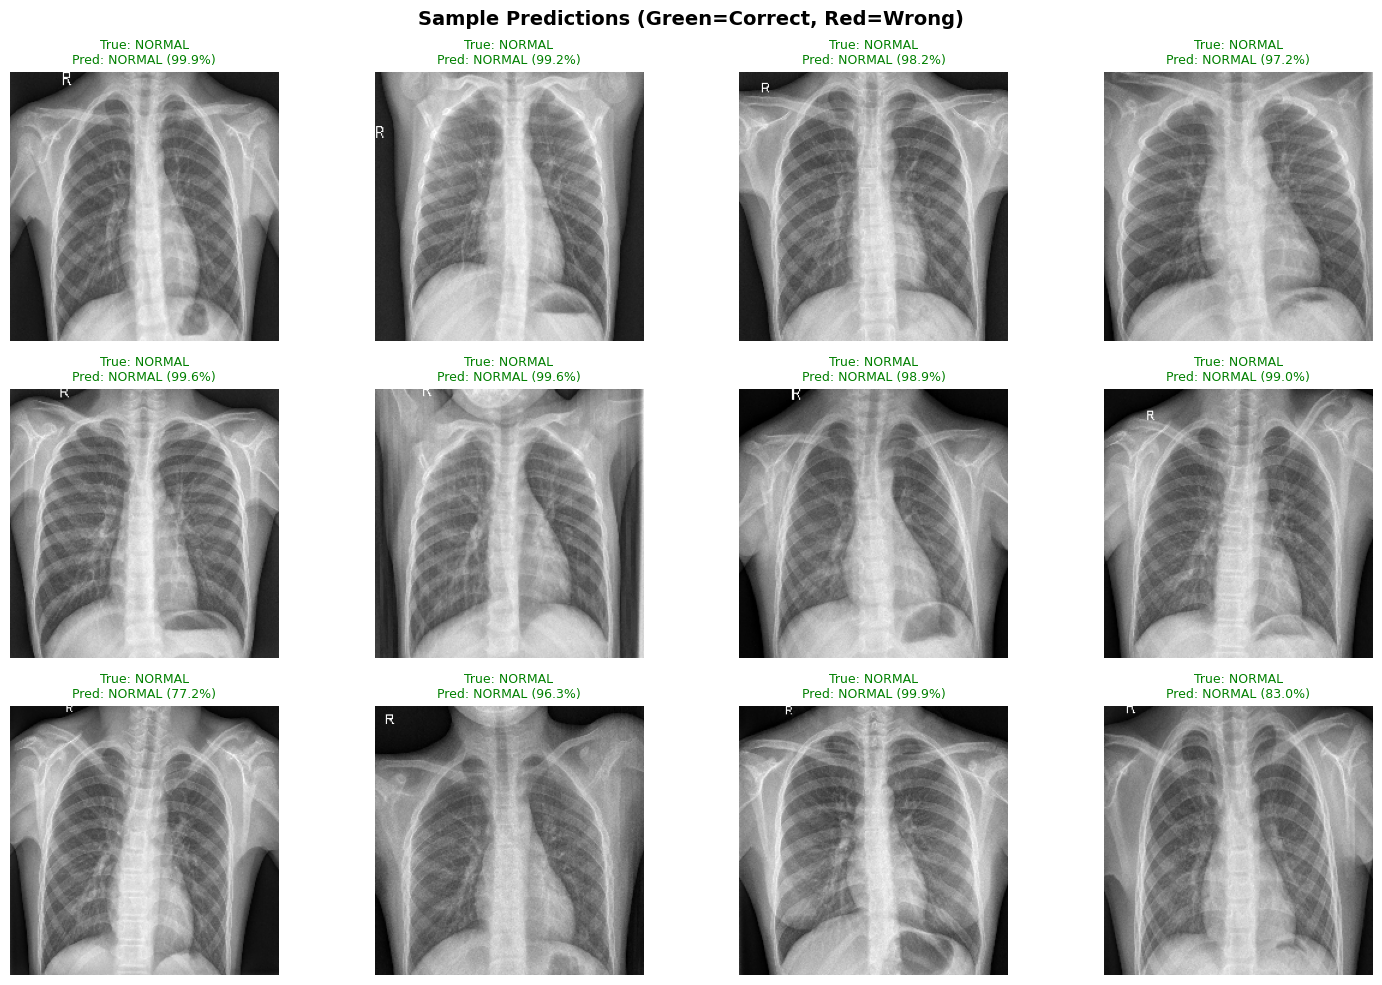

In [22]:
#22. Visualize Some Predictions
test_data.reset()
images, labels = next(test_data)
predictions = densenet_model.predict(images, verbose=0)

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])

    true_label = 'PNEUMONIA' if labels[i] == 1 else 'NORMAL'
    pred_label = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL'
    confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence*100:.1f}%)',
              color=color, fontsize=9)
    plt.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()